## Pd3 Jamroży Bartosz

In [ ]:
library(tidyverse)
library(reshape2)


library(DALEX)
library(DALEXtra)


options(warn=-1)

Dane z: https://www.kaggle.com/camnugent/california-housing-prices

In [6]:
house <- read.csv(file = 'housing.csv', stringsAsFactors = FALSE)

# Model
przykładowy model z : https://www.kaggle.com/camnugent/introduction-to-machine-learning-in-r-tutorial

In [ ]:
library(tidyverse)
library(reshape2)

housing = read.csv("housing.csv")

# clean data
housing$total_bedrooms[is.na(housing$total_bedrooms)] = median(housing$total_bedrooms , na.rm = TRUE)

#Fix the total columns - make them means
housing$mean_bedrooms = housing$total_bedrooms/housing$households
housing$mean_rooms = housing$total_rooms/housing$households

drops = c('total_bedrooms', 'total_rooms')
housing = housing[ , !(names(housing) %in% drops)]

#Turn categoricals into booleans
categories = unique(housing$ocean_proximity)

#split the categories off
cat_housing = data.frame(ocean_proximity = housing$ocean_proximity)

for(cat in categories){
  cat_housing[,cat] = rep(0, times= nrow(cat_housing))
}


for(i in 1:length(cat_housing$ocean_proximity)){
  cat = as.character(cat_housing$ocean_proximity[i])
  cat_housing[,cat][i] = 1
}

cat_columns = names(cat_housing)
keep_columns = cat_columns[cat_columns != 'ocean_proximity']
cat_housing = select(cat_housing,one_of(keep_columns))

#Scale the numerical variables

drops = c('ocean_proximity','median_house_value')
housing_num =  housing[ , !(names(housing) %in% drops)]

scaled_housing_num = scale(housing_num)

#Merge the altered numerical and categorical dataframes
cleaned_housing = cbind(cat_housing, scaled_housing_num, median_house_value=housing$median_house_value)


# Create a test set of data

set.seed(1738) # Set a random seed so that same sample can be reproduced in future runs

sample = sample.int(n = nrow(cleaned_housing), size = floor(.8*nrow(cleaned_housing)), replace = F)
train = cleaned_housing[sample, ] #just the samples
test  = cleaned_housing[-sample, ] #everything but the samples

#Random forest model
library('randomForest')

set.seed(1738)

train_y = train[,'median_house_value']
train_x = train[, names(train) !='median_house_value']

rf_model = randomForest(train_x, y = train_y , ntree = 500, importance = TRUE)


### Tworzenie explainera
W tym zadaniu używam zbioru treningowego.

In [8]:
rf_model_expain <- DALEX::explain(model = rf_model, data=train_x, y=train_y)

Preparation of a new explainer is initiated
  -> model label       :  randomForest  (  default  )
  -> data              :  16512  rows  13  cols 
  -> target variable   :  16512  values 
  -> predict function  :  yhat.randomForest  will be used (  default  )
  -> predicted values  :  No value for predict function target column. (  default  )
  -> model_info        :  package randomForest , ver. 4.6.14 , task regression (  default  ) 
  -> predicted values  :  numerical, min =  39702.65 , mean =  206688.3 , max =  499518.2  
  -> residual function :  difference between y and yhat (  default  )
  -> residuals         :  numerical, min =  -126586.5 , mean =  -173.9163 , max =  195986.5  
  A new explainer has been created!  


## Przykładowa predykcja

Predykcja dla setnej obserwacji:

In [9]:
predict(rf_model,train_x[100,])

14117 
110367.5

Wartość rzeczywista:

In [10]:
train_y[100]

[1] 102900

Dla obserwacji numer 100 ze zbioru treningowego model wyznaczył cenę nieruchomości na ok 110367 wobec rzeczywistej wartości 102900, myląc się o mniej niż 8%.

## Dekompozycja Ceteris Paribus 

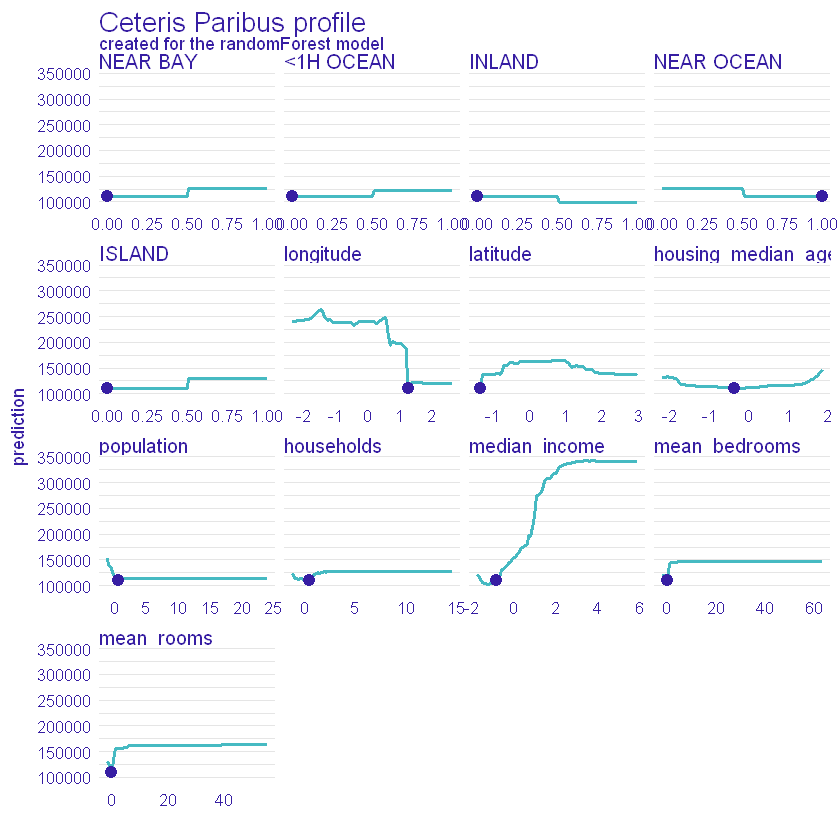

In [12]:
cp_100 <- predict_profile(rf_model_expain,
                          train[100,],
                         grid_points = 101)
plot(cp_100)

Podczas przygotowywania  danych zmienna kategoryczna ocean_proximity została rozdzielona poprzez one hot encoding na 5 osobnych kolumn ('NEAR BAY' '<1H OCEAN' 'INLAND' 'NEAR OCEAN' 'ISLAND')  Ceteris Paribus traktuje je jako zmienne ciągłe wyliczając dla nich z osobna wyniki. Podejście to tworzy patologiczne przypadki ,które nie wystąpią w naszych danych  np. nieruchomość należącą jednocześnie blisko oceanu i daleko oceanu 

Najbardziej znaczące dla modemu była długość seraficzna oraz mediana dochodów (zmiany tych parametrów najbardziej wpływały na przewidywania)

Widać dwie cechy mające największy wpływ na predykcje modelu, „median income” oraz longnitude.
Im w bogatszej okolicy znajduje się dom tym droższy jest. Połącznie to wydaje się jak najbardziej logiczne, zamożniejszy ludzie mogą pozwolić sobie na droższe nieruchomości, a te często zgrupowane danych dzielnicach 

Ciekawe zachowanie przybiera także zmienna wieku domu, droższe są domy stare i bardzo młode

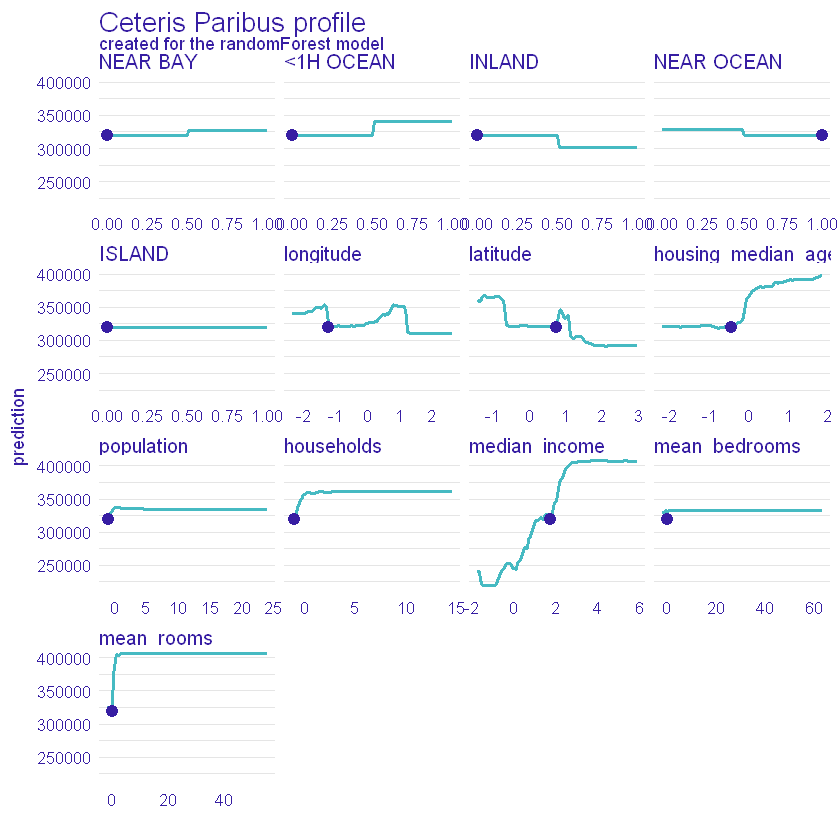

In [14]:
cp_400 <- predict_profile(rf_model_expain,
                          train_x[400,],
                         grid_points = 101)
plot(cp_400)

Dla następnej nieruchomości dochód mieszkańców ma bardzo podobny wpływ.

Jednak na oba przewidywania odmiennie wpływa szerokość geograficzna. Dla pierwszej obserwacji największy pozytywny wpływ miała przy środkowej wartości, w przypadku drugim były to małe wartości. Może to wynikać z nierównomiernego rozłożenia nieruchomości 

Spora różnica występuje także  przypadku wieku nierychłości, dla drugiej obserwacji zdecydowanie promowane są starsze dzielnice,  gdzie poprzednio raczej nie miało to znaczenia 

Dziwny jest natomiast zupełnie odwrotny wpływ liczby mieszkańców, raz wiesza liczba ludność podwyższała wartości nieruchomości, a raz obniżała. Nie widzę tutaj żadnego racjonalnego wytłumaczenia

## Wnioski
Z powodu używania przez model one hot encoding Ceteris Paribus potrafi pokazywać dziwne przypadki. Paribus wskazuje jako najważniejszą cechę mediany dochodu, tak jak Break Down oraz metoda lime. Jednak dla innych cech wykresy są mało mówiące.